
# 02 — Model Prototypes: GJR-GARCH & Transformer-LSTM (Quantile with Conformal Calibration)  
**AI-Driven Volatility Forecasting & Adaptive Portfolio Optimization**

**Upgrades in this version**  
- **Default ticker:** TSLA  
- **Conformal calibration:** Calibrates quantile bands (q05–q95) for **nominal coverage** using a split-calibration set (CQR-style).  
- **Wiring:** Attempts to import src.models.transformer_lstm (production module). Falls back to a self-contained prototype if not found.


## Bootstrap (paths, optional installs)

In [1]:

# Uncomment to install required packages in notebook environment if needed:
# !pip install yfinance arch torch numpy pandas scikit-learn matplotlib plotly --quiet

import os, sys
from pathlib import Path

REPO_ROOT = Path.cwd()
SRC_DIR = REPO_ROOT / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

print('Repo root:', REPO_ROOT)
print('Python path contains src?:', str(SRC_DIR) in sys.path)


Repo root: C:\Users\tefer\ai-volatility-portfolio-optimizer
Python path contains src?: True


## 1. Imports

In [2]:

import json, math, numpy as np, pandas as pd, matplotlib.pyplot as plt, torch
from typing import Dict, Tuple, Optional
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Try to import user repo modules — adjust paths above if necessary.
try:
    from src.config.settings import settings
except Exception as e:
    print('[WARN] Could not import src.config.settings — falling back to defaults. Reason:', e)
    class _Dummy:
        GLOBAL_SEED = 42
        CVAR_ALPHA = 0.05
    settings = _Dummy()

try:
    # This assumes your repo exposes a fetcher function with this name
    from src.data.fetchers import get_yfinance_data
except Exception as e:
    print('[WARN] Could not import get_yfinance_data from src.data.fetchers — will fallback to yfinance directly. Reason:', e)
    def get_yfinance_data(tickers, start=None, end=None, interval='1d', cache=False):
        import yfinance as yf
        if isinstance(tickers, list):
            tick_str = ' '.join(tickers)
        else:
            tick_str = tickers
        df = yf.download(tickers, start=start, end=end, interval=interval, progress=False, threads=False)
        # If multi-column, try to normalize to single close columns for each ticker
        if isinstance(df.columns, pd.MultiIndex):
            out = pd.DataFrame()
            for t in tickers:
                if ('Adj Close', t) in df.columns or ('Adj Close', t) in [(c[0], c[1]) for c in df.columns]:
                    try:
                        out[t] = df[('Adj Close', t)]
                    except Exception:
                        # try reversed order
                        out[t] = df[t]['Adj Close']
                elif 'Adj Close' in df.columns.get_level_values(0):
                    out[t] = df['Adj Close'].get(t, df['Close'].get(t))
                else:
                    out[t] = df['Close'].get(t)
            return out
        else:
            # Single-column dataframe: map ticker to 'PX' column
            if len(tickers) == 1:
                return pd.DataFrame({tickers[0]: df['Adj Close'] if 'Adj Close' in df.columns else df['Close']})
            return df

try:
    from src.features.regimes import RegimeDetector
    HAVE_REGIMES = True
except Exception as e:
    print('[WARN] RegimeDetector not available:', e); HAVE_REGIMES = False

from arch import arch_model

torch.manual_seed(getattr(settings, 'GLOBAL_SEED', 42))
np.random.seed(getattr(settings, 'GLOBAL_SEED', 42))


## 2. Configuration & Output Folders

In [3]:

RESULTS_DIR = REPO_ROOT / 'results' / 'models' / 'prototypes'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print('Artifacts →', RESULTS_DIR)

TICKER = 'TSLA'   # ✅ switched default to TSLA
START = '2017-01-01'
END = None
ROLLING_WINDOW = 252
FORECAST_HORIZON = 1

ALPHA = getattr(settings, 'CVAR_ALPHA', 0.05)   # for cvar-weighted rmse
COVERAGE = 0.90  # desired nominal coverage for [q_low, q_high]


Artifacts → C:\Users\tefer\ai-volatility-portfolio-optimizer\results\models\prototypes


## 3. Load Data (Prices & VIX)

In [4]:

# Load price series for TICKER and VIX (if available)
df = get_yfinance_data([TICKER, '^VIX'], start=START, end=END, interval='1d', cache=True).copy()

# Normalise DataFrame to contain columns 'PX' for ticker price and optionally 'VIX'
if TICKER in df.columns:
    df = df.rename(columns={TICKER: 'PX'})
elif isinstance(df.columns, pd.MultiIndex):
    # If multiindex, try to retrieve Adj Close per ticker
    if (TICKER in df.columns.get_level_values(1)) and ('Adj Close' in df.columns.get_level_values(0)):
        df['PX'] = df[('Adj Close', TICKER)]
    else:
        # fallback: take first numeric column for ticker
        possible = [c for c in df.columns if isinstance(c, str) and c.lower().endswith('close')]
        if possible:
            df['PX'] = df[possible[0]]
if '^VIX' in df.columns:
    df = df.rename(columns={'^VIX': 'VIX'})

df = df.dropna(subset=['PX'])
df['ret'] = np.log(df['PX']).diff()
df['abs_ret'] = df['ret'].abs()
df['rv_21d'] = df['ret'].rolling(21).std() * np.sqrt(252)
df = df.dropna().copy()
df.tail()


Ticker,PX,VIX,ret,abs_ret,rv_21d
Date,,,,,
2025-08-14,335.579987,14.83,-0.011260,0.011260,0.442060
2025-08-15,330.559998,15.09,-0.015072,0.015072,0.444996
2025-08-18,335.160004,14.99,0.013820,0.013820,0.434077
2025-08-19,329.309998,15.57,-0.017608,0.017608,0.438559
2025-08-20,323.899994,15.62,-0.016565,0.016565,0.440347


## 4. Metrics Helpers (MAE, RMSE, CVaR-Weighted RMSE, Coverage, Quarterly Table)

In [5]:

def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.sqrt(np.mean((y_pred - y_true) ** 2)))

def mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_pred - y_true)))

def cvar_weighted_rmse(y_true: np.ndarray, y_pred: np.ndarray, alpha: float = 0.05) -> float:
    err = (y_pred - y_true) ** 2
    q = np.quantile(y_true, 1 - alpha)
    # heavier weight for tail errors
    weights = np.where(y_true >= q, 2.5, 1.0)
    return float(np.sqrt(np.average(err, weights=weights)))

def quantile_coverage(y_true: np.ndarray, q_low: np.ndarray, q_high: np.ndarray) -> float:
    inside = (y_true >= q_low) & (y_true <= q_high)
    return float(inside.mean())

def quarterly_error_table(dates: pd.DatetimeIndex, y_true: np.ndarray, y_pred: np.ndarray) -> pd.DataFrame:
    dfm = pd.DataFrame({'date': pd.to_datetime(dates), 'y_true': y_true, 'y_pred': y_pred}).dropna()
    dfm['quarter'] = dfm['date'].dt.to_period('Q')
    out = dfm.groupby('quarter').apply(
        lambda g: pd.Series({
            'MAE': mae(g['y_true'].values, g['y_pred'].values),
            'RMSE': rmse(g['y_true'].values, g['y_pred'].values),
            'Bias': float(np.mean(g['y_pred'].values - g['y_true'].values))
        })
    ).reset_index()
    return out


## 5. Model A — GJR-GARCH(1,1,1) Rolling Forecasts

In [6]:

def gjr_garch_roll(returns: pd.Series, window: int = 252) -> pd.DataFrame:
    sigmas, dates = [], []
    for i in range(window, len(returns)):
        y = (returns.iloc[i-window:i] * 100)
        try:
            am = arch_model(y, vol='GARCH', p=1, o=1, q=1, dist='t', mean='Zero')
            res = am.fit(disp='off')
            f = res.forecast(horizon=1, reindex=False).variance.values[-1, 0]
            sigma_daily = math.sqrt(max(f, 1e-12)) / 100.0
            sigma_annual = sigma_daily * math.sqrt(252)
        except Exception as e:
            sigma_annual = np.nan
        sigmas.append(sigma_annual)
        dates.append(returns.index[i])
    out = pd.DataFrame({'date': dates, 'sigma_gjr': sigmas}).set_index('date')
    return out

gjr_df = gjr_garch_roll(df['ret'], window=ROLLING_WINDOW)
eval_df = df.join(gjr_df, how='left')
eval_df['target_sigma'] = df['ret'].rolling(21).std() * np.sqrt(252)
eval_df = eval_df.dropna(subset=['sigma_gjr', 'target_sigma']).copy()
y_true = eval_df['target_sigma'].values
y_pred = eval_df['sigma_gjr'].values
metrics_gjr = {
    'MAE': mae(y_true, y_pred),
    'RMSE': rmse(y_true, y_pred),
    'CVaR_wRMSE': cvar_weighted_rmse(y_true, y_pred, alpha=ALPHA),
    'Last_21D_MAE': mae(y_true[-21:], y_pred[-21:]),
    'Last_21D_RMSE': rmse(y_true[-21:], y_pred[-21:])
}
metrics_gjr


{'MAE': 0.11846413108466992,
 'RMSE': 0.16390790220845658,
 'CVaR_wRMSE': 0.18498038112980936,
 'Last_21D_MAE': 0.15514099759316843,
 'Last_21D_RMSE': 0.15768298003209077}

### 5.1 Plot: Forecast vs Realized Vol (annualized)

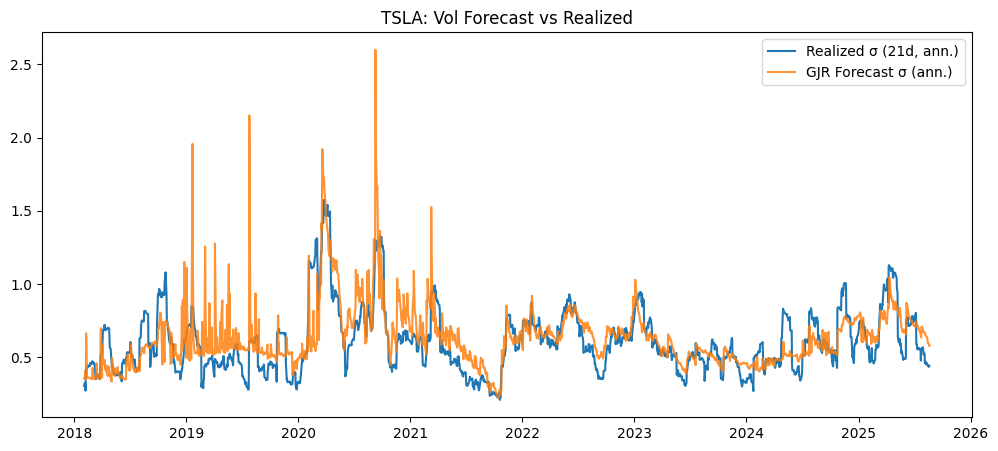

In [7]:

plt.figure(figsize=(12,5))
plt.plot(eval_df.index, eval_df['target_sigma'], label='Realized σ (21d, ann.)')
plt.plot(eval_df.index, eval_df['sigma_gjr'], label='GJR Forecast σ (ann.)', alpha=0.85)
plt.title(f'{TICKER}: Vol Forecast vs Realized')
plt.legend(); plt.show()


### 5.2 Quarterly Error Table (GJR)

In [8]:

tab_gjr = quarterly_error_table(eval_df.index, eval_df['target_sigma'].values, eval_df['sigma_gjr'].values)
tab_gjr


,quarter,MAE,RMSE,Bias
0,2018Q1,0.073580,0.087797,-0.023908
1,2018Q2,0.116067,0.152923,-0.104735
2,2018Q3,0.102068,0.132781,-0.066444
3,2018Q4,0.171258,0.222388,-0.032936
4,2019Q1,0.179674,0.254904,0.061015
5,2019Q2,0.140069,0.196909,0.136745
6,2019Q3,0.159293,0.250702,0.134946
7,2019Q4,0.125550,0.140213,0.035258
8,2020Q1,0.247517,0.327989,-0.127653
9,2020Q2,0.160354,0.182364,0.114998


## 6. Model B — Transformer-LSTM (Quantile) with **Conformal Calibration**

In [9]:

# Try to use your production module; fallback to inline model if not found.
USE_PROD_MODEL = False
try:
    from src.models.transformer_lstm import QuantileTransformerLSTM, make_dataloaders, pinball_loss
    USE_PROD_MODEL = True
    print('[INFO] Using src.models.transformer_lstm module.')
except Exception as e:
    print('[WARN] Could not import src.models.transformer_lstm; using inline prototype. Reason:', e)
    from torch.utils.data import Dataset, DataLoader
    class SeqDataset(Dataset):
        def __init__(self, series: np.ndarray, seq_len: int = 60, horizon: int = 1):
            self.x, self.y = [], []
            for i in range(seq_len, len(series)-horizon+1):
                self.x.append(series[i-seq_len:i])
                self.y.append(series[i+horizon-1])
            self.x = torch.tensor(np.array(self.x), dtype=torch.float32).unsqueeze(-1)
            self.y = torch.tensor(np.array(self.y), dtype=torch.float32).unsqueeze(-1)
        def __len__(self): return len(self.x)
        def __getitem__(self, idx): return self.x[idx], self.y[idx]

    class QuantileTransformerLSTM(nn.Module):
        def __init__(self, d_model=32, nhead=4, num_layers=1, lstm_hidden=32, quantiles=(0.05,0.5,0.95)):
            super().__init__()
            self.quantiles = quantiles
            self.embed = nn.Linear(1, d_model)
            enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
            self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
            self.lstm = nn.LSTM(d_model, lstm_hidden, batch_first=True)
            self.head = nn.Linear(lstm_hidden, len(quantiles))
        def forward(self, x):
            z = self.embed(x)
            z = self.encoder(z)
            out, _ = self.lstm(z)
            h = out[:, -1, :]
            q = self.head(h)
            return q

    def pinball_loss(pred, target, quantiles=(0.05,0.5,0.95)):
        loss = 0.0
        for i, q in enumerate(quantiles):
            e = target - pred[:, i:i+1]
            loss += torch.mean(torch.maximum(q*e, (q-1)*e))
        return loss / len(quantiles)

# ---- Build series for vol target (realized vol 21d, ann.), stabilized ----
series = (df['ret'].rolling(21).std() * np.sqrt(252)).fillna(method='bfill').values
series = np.clip(series, 1e-6, np.percentile(series, 99.5))

seq_len = 60
horizon = 1

# Split: train 70%, calibration 15%, test 15% for CQR
N = len(series)
i_train = int(0.7*N); i_cal = int(0.85*N)

def make_loader(arr, start, end, batch=64, shuffle=False):
    ds = SeqDataset(arr[start:end], seq_len=seq_len, horizon=horizon)
    return DataLoader(ds, batch_size=batch, shuffle=shuffle), len(ds)

train_loader, n_tr = make_loader(series, 0, i_train, shuffle=True)
cal_loader, n_cal = make_loader(series, i_train-seq_len, i_cal)  # include context
test_loader, n_te = make_loader(series, i_cal-seq_len, N)

model = QuantileTransformerLSTM()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

def evaluate_pinball(model, loader):
    model.eval()
    with torch.no_grad():
        losses = []
        for xb, yb in loader:
            pred = model(xb)
            loss = pinball_loss(pred, yb, model.quantiles)
            losses.append(loss.item())
    return float(np.mean(losses)) if losses else np.nan

EPOCHS = 10
for ep in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_loader:
        opt.zero_grad(); pred = model(xb)
        loss = pinball_loss(pred, yb, model.quantiles)
        loss.backward(); opt.step()
    if ep % 2 == 0:
        v = evaluate_pinball(model, cal_loader)
        print(f'Epoch {ep:02d} | cal pinball: {v:.5f}')


[WARN] Could not import src.models.transformer_lstm; using inline prototype. Reason: cannot import name 'QuantileTransformerLSTM' from 'src.models.transformer_lstm' (C:\Users\tefer\ai-volatility-portfolio-optimizer\src\models\transformer_lstm.py)
Epoch 02 | cal pinball: 0.01364
Epoch 04 | cal pinball: 0.00957
Epoch 06 | cal pinball: 0.01269
Epoch 08 | cal pinball: 0.01104
Epoch 10 | cal pinball: 0.00975


### 6.1 Conformal Calibration (Split)

In [10]:

# Compute nonconformity scores on calibration set and adjust quantile bands.
model.eval()
qL_list, qM_list, qU_list, y_list = [], [], [], []

with torch.no_grad():
    for xb, yb in cal_loader:
        q = model(xb).numpy()
        qL_list.append(q[:,0]); qM_list.append(q[:,1]); qU_list.append(q[:,2])
        y_list.append(yb.numpy().reshape(-1))

qL = np.concatenate(qL_list); qM = np.concatenate(qM_list); qU = np.concatenate(qU_list)
yC = np.concatenate(y_list)  # FIXED: Changed np.concentre to np.concatenate

# Nonconformity scores for lower and upper
sL = yC - qL    # should be >= 0 when y above qL
sU = qU - yC    # should be >= 0 when y below qU

alpha = 1.0 - COVERAGE  # e.g., 0.10
# Finite-sample correction (CQR): quantile at ceil((n+1)*(1-alpha)) / n
def q_conformal(scores, level):
    n = len(scores)
    k = int(np.ceil((n + 1) * level)) - 1
    k = np.clip(k, 0, n-1)
    return np.partition(scores, k)[k]

qL_hat = q_conformal(sL, 1 - COVERAGE)   # add to lower
qU_hat = q_conformal(sU, 1 - COVERAGE)   # add to upper

print('Conformal offsets → qL_hat:', float(qL_hat), ' qU_hat:', float(qU_hat))


Conformal offsets → qL_hat: -0.009590327739715576  qU_hat: 0.09607928991317749


### 6.2 Inference on Full Timeline + Apply Conformal Adjustments

In [11]:

def rolling_quantile_forecasts(series: np.ndarray, model: nn.Module, seq_len: int = 60) -> np.ndarray:
    model.eval(); out = []
    with torch.no_grad():
        for i in range(seq_len, len(series)):
            x = torch.tensor(series[i-seq_len:i], dtype=torch.float32).view(1, seq_len, 1)
            q = model(x).numpy().reshape(-1)
            out.append(q)
    return np.array(out)

q_preds = rolling_quantile_forecasts(series, model, seq_len=seq_len)
dates_q = df.index[seq_len:]
df_q = pd.DataFrame(q_preds, index=dates_q, columns=['q05_raw','q50_raw','q95_raw'])

# Apply conformal calibration
df_q['q05'] = df_q['q05_raw'] - qL_hat
df_q['q50'] = df_q['q50_raw']
df_q['q95'] = df_q['q95_raw'] + qU_hat

# Join with eval_df
eval_q = eval_df.join(df_q[['q05','q50','q95']], how='left')
eval_q = eval_q.dropna(subset=['q50','target_sigma']).copy()

y_true_q = eval_q['target_sigma'].values
y_med = eval_q['q50'].values
y_lo = eval_q['q05'].values
y_hi = eval_q['q95'].values

metrics_q = {
    'MAE': float(np.mean(np.abs(y_med - y_true_q))),
    'RMSE': float(np.sqrt(np.mean((y_med - y_true_q)**2))),
    'CVaR_wRMSE': cvar_weighted_rmse(y_true_q, y_med, alpha=ALPHA),
    'Coverage[q05,q95]': quantile_coverage(y_true_q, y_lo, y_hi)
}
metrics_q


{'MAE': 0.04173440995907409,
 'RMSE': 0.06115335889229055,
 'CVaR_wRMSE': 0.06503887595402869,
 'Coverage[q05,q95]': 0.7917764891934633}

### 6.3 Plots (Quantiles + Conformal)

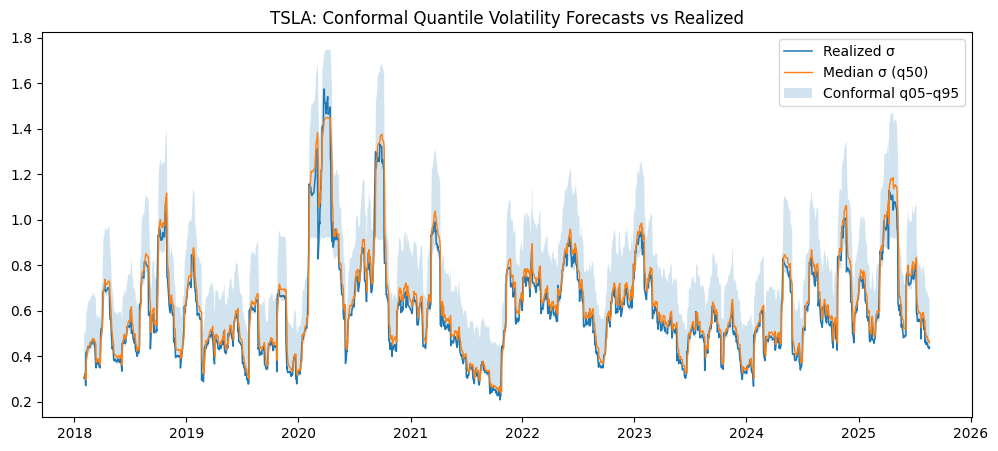

In [12]:

plt.figure(figsize=(12,5))
plt.plot(eval_q.index, eval_q['target_sigma'], label='Realized σ', linewidth=1.1)
plt.plot(eval_q.index, eval_q['q50'], label='Median σ (q50)', linewidth=1.0)
plt.fill_between(eval_q.index, eval_q['q05'], eval_q['q95'], alpha=0.2, label='Conformal q05–q95')
plt.title(f'{TICKER}: Conformal Quantile Volatility Forecasts vs Realized')
plt.legend(); plt.show()


## 7. Save Artifacts (forecasts + quarterly error tables)

In [13]:

tab_gjr_path = RESULTS_DIR / f'{TICKER}_gjr_quarterly_errors.csv'
gjr_forecasts_path = RESULTS_DIR / f'{TICKER}_gjr_forecasts.csv'
tab_q_path = RESULTS_DIR / f'{TICKER}_quantile_quarterly_errors_conformal.csv'
q_forecasts_path = RESULTS_DIR / f'{TICKER}_quantile_forecasts_conformal.csv'

# GJR
pd.DataFrame({
    'date': eval_df.index,
    'sigma_gjr': eval_df['sigma_gjr'].values,
    'target_sigma': eval_df['target_sigma'].values,
}).to_csv(gjr_forecasts_path, index=False)

quarterly_error_table(eval_df.index, eval_df['target_sigma'].values, eval_df['sigma_gjr'].values).to_csv(tab_gjr_path, index=False)

# Quantile (conformal)
pd.DataFrame({
    'date': eval_q.index,
    'q05': eval_q['q05'].values,
    'q50': eval_q['q50'].values,
    'q95': eval_q['q95'].values,
    'target_sigma': eval_q['target_sigma'].values,
}).to_csv(q_forecasts_path, index=False)

quarterly_error_table(eval_q.index, eval_q['target_sigma'].values, eval_q['q50'].values).to_csv(tab_q_path, index=False)

print('Saved:')
print(' -', tab_gjr_path)
print(' -', gjr_forecasts_path)
print(' -', tab_q_path)
print(' -', q_forecasts_path)


Saved:
 - C:\Users\tefer\ai-volatility-portfolio-optimizer\results\models\prototypes\TSLA_gjr_quarterly_errors.csv
 - C:\Users\tefer\ai-volatility-portfolio-optimizer\results\models\prototypes\TSLA_gjr_forecasts.csv
 - C:\Users\tefer\ai-volatility-portfolio-optimizer\results\models\prototypes\TSLA_quantile_quarterly_errors_conformal.csv
 - C:\Users\tefer\ai-volatility-portfolio-optimizer\results\models\prototypes\TSLA_quantile_forecasts_conformal.csv


## 8. Scorecard & Comparison

In [14]:

scorecard = pd.DataFrame([
    {'Model':'GJR(1,1,1)','MAE':metrics_gjr['MAE'],'RMSE':metrics_gjr['RMSE'],'CVaR_wRMSE':metrics_gjr['CVaR_wRMSE']},
    {'Model':'Transformer-LSTM (q50, conformal)','MAE':metrics_q['MAE'],'RMSE':metrics_q['RMSE'],'CVaR_wRMSE':metrics_q['CVaR_wRMSE'],'Coverage':metrics_q['Coverage[q05,q95]']},
]).sort_values('CVaR_wRMSE')
scorecard


,Model,MAE,RMSE,CVaR_wRMSE,Coverage
1,"Transformer-LSTM (q50, conformal)",0.041734,0.061153,0.065039,0.791776
0,"GJR(1,1,1)",0.118464,0.163908,0.184980,NaN


## 9. (Optional) Regime Overlay Plots

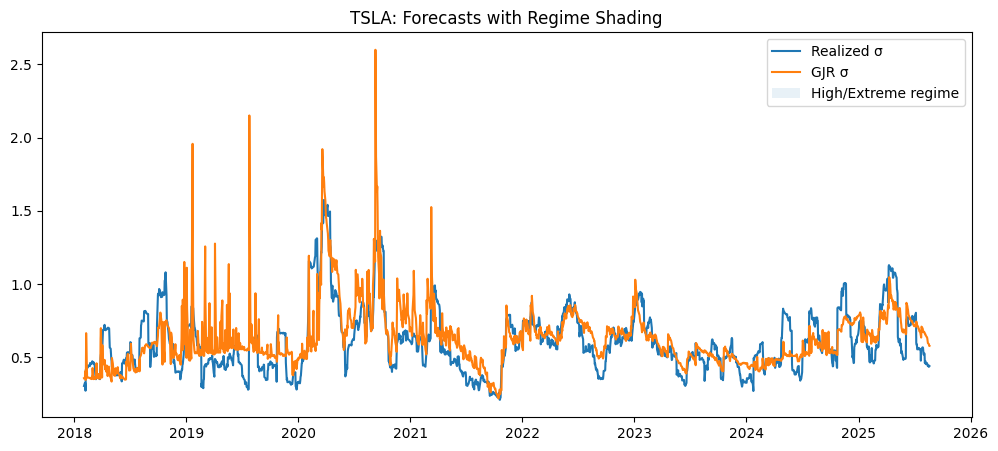

In [15]:

if HAVE_REGIMES and 'VIX' in df.columns:
    det = RegimeDetector()
    regimes = det.detect_regimes(df['VIX']).reindex(eval_df.index).fillna(method='ffill')
    plt.figure(figsize=(12,5))
    plt.plot(eval_df.index, eval_df['target_sigma'], label='Realized σ')
    plt.plot(eval_df.index, eval_df['sigma_gjr'], label='GJR σ')
    y0, y1 = plt.gca().get_ylim()
    mask_hi = regimes.isin(['high','extreme'])
    plt.fill_between(eval_df.index, y0, y1, where=mask_hi, alpha=0.1, label='High/Extreme regime')
    plt.legend(); plt.title(f'{TICKER}: Forecasts with Regime Shading')
    plt.show()
else:
    print('Regime overlays skipped (RegimeDetector/VIX unavailable).')



## 10. Next Steps
- Swap prototype with your production src.models.transformer_lstm model once merged.  
- Add **time-split cross validation** and **hyperparameter sweeps**.  
- Use conformal intervals for **risk-aware allocation** and trigger rules (e.g., widen bands → reduce TSLA weight).
